In [1]:
# Step 3.1: imports, device and paths
import os, random
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

# device (CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device detected:", device)

# dataset paths (verify they exist)
ROIS_DIR = Path("data/rois/images")
TRAIN_CSV = Path("data/rois/train_labels.csv")
VAL_CSV   = Path("data/rois/val_labels.csv")
CKPT_DIR  = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)

assert ROIS_DIR.exists(), f"ROIs dir not found: {ROIS_DIR}"
assert TRAIN_CSV.exists(), f"Train CSV not found: {TRAIN_CSV}"
assert VAL_CSV.exists(), f"Val CSV not found: {VAL_CSV}"
print("Paths OK.")


C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device detected: cpu
Paths OK.


In [2]:
# Step 3.2: Dataset class to read ROI CSVs
class ROIDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = Path(img_dir)
        self.transform = transform
        # label mapping
        labels = sorted(self.df['label'].unique())
        self.label2idx = {lab: i for i, lab in enumerate(labels)}
        self.idx2label = {i: lab for lab, i in self.label2idx.items()}
        self.df['label_idx'] = self.df['label'].map(self.label2idx)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row['roi_filename']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, int(row['label_idx'])


In [6]:
# === Step 3.3 (Ultra-fast) ===
IMG_SIZE = 224
BATCH_SIZE = 8        # smaller for faster CPU
NUM_WORKERS = 0
PIN_MEMORY = False

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(6),
    T.ColorJitter(0.10,0.10,0.10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = ROIDataset(TRAIN_CSV, ROIS_DIR, transform=train_transform)
val_ds   = ROIDataset(VAL_CSV, ROIS_DIR, transform=val_transform)
num_classes = len(train_ds.label2idx)
print("Num classes:", num_classes, "Train rows:", len(train_ds), "Val rows:", len(val_ds))
print("IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


Num classes: 6 Train rows: 22176 Val rows: 5544
IMG_SIZE: 224 BATCH_SIZE: 8


In [7]:
# === Step 3.4 (Ultra-fast: EfficientNet-B0 + freeze backbone) ===
def build_model_b0(num_classes, pretrained=True):
    model = timm.create_model("efficientnet_b0", pretrained=pretrained, num_classes=num_classes)
    return model

model = build_model_b0(num_classes=num_classes, pretrained=True)
model = model.to(device)

# Freeze backbone for ultra-fast training
FREEZE_BACKBONE = True
if FREEZE_BACKBONE:
    for name, p in model.named_parameters():
        if "classifier" not in name and "fc" not in name:
            p.requires_grad = False
    print("Backbone frozen. Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
else:
    print("Backbone NOT frozen. Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


Backbone frozen. Trainable params: 7686


In [8]:
# === Step 3.5 (Ultra-fast training loop) ===
NUM_EPOCHS = 2   # ultra-fast
best_val_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, NUM_EPOCHS+1):
    # TRAIN
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [train]", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=(running_loss/total), acc=(correct/total))

    train_loss = running_loss/total
    train_acc = correct/total

    # VALIDATION
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [val]", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    val_loss = running_loss/total
    val_acc = correct/total

    scheduler.step(val_loss)
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    # checkpoint best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "label2idx": train_ds.label2idx,
            "img_size": IMG_SIZE,
            "epoch": epoch,
            "val_acc": val_acc
        }, CKPT_DIR / "best_effnet_b0_cpu_ultrafast.pth")
        print("Saved best checkpoint at epoch", epoch)


Epoch 1: train_loss=2.8968 train_acc=0.1656 | val_loss=2.8357 val_acc=0.1658
Saved best checkpoint at epoch 1


Epoch 2: train_loss=2.5273 train_acc=0.1682 | val_loss=2.6202 val_acc=0.1681
Saved best checkpoint at epoch 2


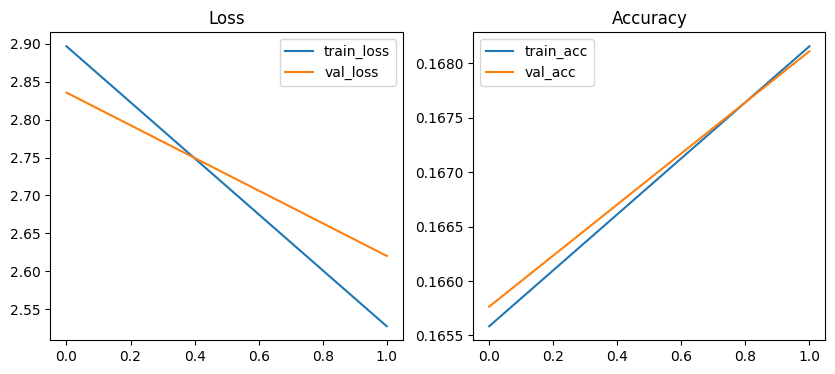

Final eval: 100%|████████████████████████| 693/693 [03:20<00:00,  3.46it/s]
C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lavanya R\.conda\envs\circuitguard\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

                 precision    recall  f1-score   support

   Missing_hole       0.00      0.00      0.00       920
     Mouse_bite       0.17      0.73      0.28       920
   Open_circuit       0.00      0.00      0.00       928
          Short       0.15      0.00      0.00       928
           Spur       0.00      0.00      0.00       920
Spurious_copper       0.17      0.30      0.21       928

       accuracy                           0.17      5544
      macro avg       0.08      0.17      0.08      5544
   weighted avg       0.08      0.17      0.08      5544



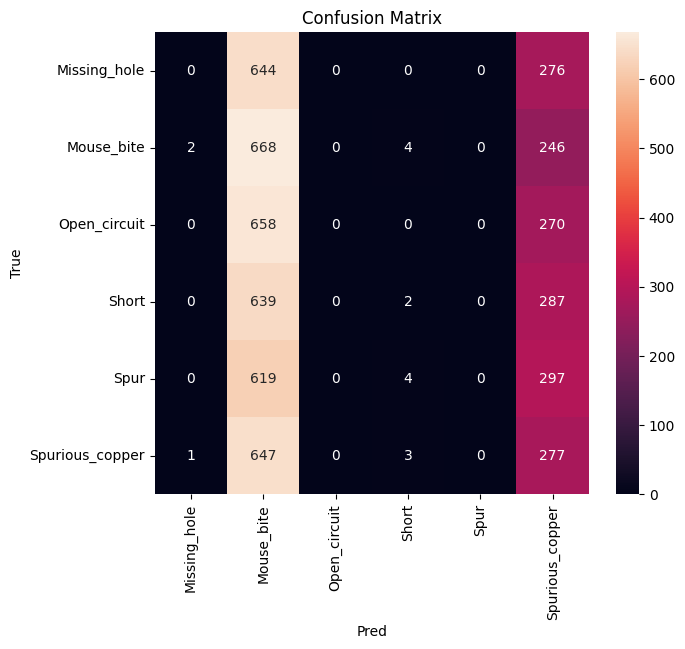

In [12]:
# Step 3.6: plot curves and print classification report
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.show()

# Load best model and evaluate on val set
ckpt = torch.load(CKPT_DIR / "best_effnet_b0_cpu.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final eval"):
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

idx2label = {v:k for k,v in train_ds.label2idx.items()}
target_names = [idx2label[i] for i in range(len(idx2label))]
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [10]:
# Step 3.7: inference helper for a single ROI image
def predict_image_pil(img_pil, model, transform, topk=3):
    model.eval()
    x = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    topk_idx = probs.argsort()[-topk:][::-1]
    return [(int(i), float(probs[i])) for i in topk_idx]

# Example usage
sample_row = pd.read_csv(TRAIN_CSV).iloc[0]
sample_path = ROIS_DIR / sample_row['roi_filename']
img_pil = Image.open(sample_path).convert('RGB')
preds = predict_image_pil(img_pil, model, val_transform, topk=3)
print("Preds (idx,prob):", preds)
print("Labels:", [(train_ds.idx2label[i], p) for i,p in preds])


Preds (idx,prob): [(1, 0.2517299950122833), (3, 0.2180405557155609), (5, 0.1854202300310135)]
Labels: [('Mouse_bite', 0.2517299950122833), ('Short', 0.2180405557155609), ('Spurious_copper', 0.1854202300310135)]


In [11]:
# Step 3.8: final model path already saved as best_effnet_b0_cpu.pth
print("Best checkpoint saved at:", CKPT_DIR / "best_effnet_b0_cpu.pth")

# Optional: export to TorchScript (may fail for some timm models)
try:
    example = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(device)
    traced = torch.jit.trace(model, example)
    traced.save(CKPT_DIR / "effnet_b0_traced_cpu.pt")
    print("TorchScript saved.")
except Exception as e:
    print("TorchScript save failed:", e)


Best checkpoint saved at: checkpoints\best_effnet_b0_cpu.pth
TorchScript saved.
